In [3]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import glob
import os
import metpy
import numpy as np
from datetime import datetime
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity
from metpy.calc import specific_humidity_from_dewpoint
from pint import UnitRegistry
ureg = UnitRegistry()
from scipy.stats import sem, t
import seaborn as sns
from scipy import stats

In [4]:
# Define file paths
file ="C:\\YEAR1\\NMVOC\\Data\\data_Meteo\\processed_met_11_23.csv"
# Read CSV files
df = pd.read_csv(file)
df

,DATETIME,wind_speed,temperature,relative_humidity,pressure
0,2011-01-18 12:00:00,6.50,4.40,33.65,793.95
1,2011-01-18 13:00:00,7.45,4.45,33.60,793.45
2,2011-01-18 14:00:00,7.25,4.55,32.10,793.10
3,2011-01-18 15:00:00,7.65,4.25,33.40,793.00
4,2011-01-18 16:00:00,8.70,3.50,32.45,793.05
...,...,...,...,...,...
98342,2023-12-31 19:00:00,5.77,4.13,77.00,795.56
98343,2023-12-31 20:00:00,6.08,3.23,88.00,795.59
98344,2023-12-31 21:00:00,6.84,3.22,86.00,795.71
98345,2023-12-31 22:00:00,6.33,3.13,85.00,795.85


In [5]:
# Convert 'DATETIME' column to datetime if not already
df["DATETIME"] = pd.to_datetime(df["DATETIME"])
# helper columns with  hour, month, year
df['hour'] = df['DATETIME'].dt.hour
df['month'] = df['DATETIME'].dt.month
df['year'] = df['DATETIME'].dt.year
df['date'] = df['DATETIME'].dt.date

In [6]:
#dewpoint from T and RH
dewpoint=dewpoint_from_relative_humidity(df["temperature"].values*units.degC, df["relative_humidity"].values*units.percent)
dewpoint

Magnitude,[-10.237803453148217 -10.21234445998266 -10.700503095760837 ... 1.1045603096469563 0.853680464042327 0.4637102659835364]
Units,degree_Celsius


In [7]:
#Specific humidity from temperature and dewpoint
SH=specific_humidity_from_dewpoint(df["pressure"].values*units.hPa, dewpoint).to('g/kg')
df ["SH"] = SH
df

,DATETIME,wind_speed,temperature,relative_humidity,pressure,hour,month,year,date,SH
0,2011-01-18 12:00:00,6.50,4.40,33.65,793.95,12,1,2011,2011-01-18,2.207619
1,2011-01-18 13:00:00,7.45,4.45,33.60,793.45,13,1,2011,2011-01-18,2.213469
2,2011-01-18 14:00:00,7.25,4.55,32.10,793.10,14,1,2011,2011-01-18,2.130331
3,2011-01-18 15:00:00,7.65,4.25,33.40,793.00,15,1,2011,2011-01-18,2.170861
4,2011-01-18 16:00:00,8.70,3.50,32.45,793.05,16,1,2011,2011-01-18,2.000443
...,...,...,...,...,...,...,...,...,...,...
98342,2023-12-31 19:00:00,5.77,4.13,77.00,795.56,19,12,2023,2023-12-31,4.955130
98343,2023-12-31 20:00:00,6.08,3.23,88.00,795.59,20,12,2023,2023-12-31,5.316184
98344,2023-12-31 21:00:00,6.84,3.22,86.00,795.71,21,12,2023,2023-12-31,5.190512
98345,2023-12-31 22:00:00,6.33,3.13,85.00,795.85,22,12,2023,2023-12-31,5.096426


In [ ]:
df.index = df.DATETIME
df.year.plot()

In [8]:
# Compute 25th and 75th percentiles for SH and WS over the whole dataset
sh_25, sh_75 = df["SH"].quantile(0.25), df["SH"].quantile(0.75)
ws_25, ws_75 = df["wind_speed"].quantile(0.25), df["wind_speed"].quantile(0.75)

# Assign computed quantiles as new columns
df["SH_25"], df["SH_75"] = sh_25, sh_75
df["WS_25"], df["WS_75"] = ws_25, ws_75

df_percentile=df
# Print  rows to check
print(df.tail())


                 DATETIME  wind_speed  temperature  relative_humidity  \
98342 2023-12-31 19:00:00        5.77         4.13               77.0   
98343 2023-12-31 20:00:00        6.08         3.23               88.0   
98344 2023-12-31 21:00:00        6.84         3.22               86.0   
98345 2023-12-31 22:00:00        6.33         3.13               85.0   
98346 2023-12-31 23:00:00        5.56         3.59               80.0   

       pressure  hour  month  year        date        SH     SH_25     SH_75  \
98342    795.56    19     12  2023  2023-12-31  4.955130  3.604031  7.210028   
98343    795.59    20     12  2023  2023-12-31  5.316184  3.604031  7.210028   
98344    795.71    21     12  2023  2023-12-31  5.190512  3.604031  7.210028   
98345    795.85    22     12  2023  2023-12-31  5.096426  3.604031  7.210028   
98346    796.01    23     12  2023  2023-12-31  4.953555  3.604031  7.210028   

       WS_25  WS_75  
98342    3.1    8.9  
98343    3.1    8.9  
98344    3.1  

In [9]:


# Apply conditions to classify data
def classify(row):
    if row["SH"] < row["SH_25"] and row["wind_speed"] > row["WS_25"]:
        return "FT"
    elif row["SH"] > row["SH_75"] and row["wind_speed"] < row["WS_25"]:
        return "PBL"
    else:
        return "Other"

df_percentile["Label"] = df_percentile.apply(classify, axis=1)



In [ ]:
# Count occurrences of each label per month
#monthly_counts = df_percentile.groupby(["month"])["Label"].value_counts().unstack(fill_value=0)
#monthly_total = monthly_counts.sum(axis=1)
#entry_count = df_percentile["Label"].count()
# Convert FT and PBL counts to percentages
#monthly_percentage = (monthly_counts.div(entry_count, axis=0)) * 100

In [8]:
# Count occurrences of each label per month
monthly_counts = df_percentile.groupby(["month"])["Label"].value_counts().unstack(fill_value=0)
# Count occurrences of 'pbl' and 'ft'
count_pbl = (df_percentile["Label"] == 'PBL').sum()
count_ft = (df_percentile["Label"] == 'FT').sum()

print(f"Count of 'pbl': {count_pbl}")
print(f"Count of 'ft': {count_ft}")
count_ft_pbl= count_ft + count_pbl
monthly_percentage = (monthly_counts.div(count_ft_pbl, axis=0)) * 100

Count of 'pbl': 8031
Count of 'ft': 19184


In [22]:
monthly_percentage

Label,FT,Other,PBL
month,,,
1,15.634760,12.309388,0.000000
2,9.652765,12.434319,0.000000
3,8.634944,17.196399,0.000000
4,6.187764,25.008267,0.022047
5,1.297079,27.782473,1.150101
6,0.360096,26.621349,6.378835
7,0.198420,24.571009,8.936248
8,0.407863,24.515892,7.822892
9,0.992100,25.533713,4.111703


In [ ]:
#ft_count = (df_percentile["Label"] == 'FT').sum()
#ft_perc=(ft_count /entry_count )*100
#print(ft_perc)


In [17]:
ft_count = (df_percentile["Label"] == 'FT').sum()
ft_perc=(ft_count /count_ft_pbl )*100
print(ft_perc)

70.4905383060812


In [ ]:
#pbl_count = (df_percentile["Label"] == 'PBL').sum()
#pbl_perc=(pbl_count /entry_count )*100
#print(pbl_perc)


In [18]:
pbl_count = (df_percentile["Label"] == 'PBL').sum()
pbl_perc=(pbl_count /count_ft_pbl)*100
print(pbl_perc)


29.509461693918794


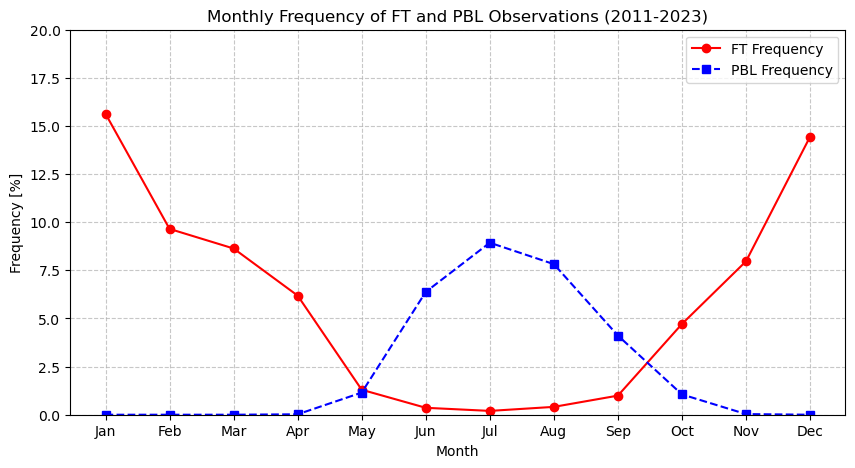

In [19]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(monthly_percentage.index, monthly_percentage["FT"], marker="o", linestyle="-", label="FT Frequency", color="red")
plt.plot(monthly_percentage.index, monthly_percentage["PBL"], marker="s", linestyle="--", label="PBL Frequency", color="blue")

# Formatting the plot
plt.xlabel("Month")
plt.ylabel("Frequency [%]")
plt.title("Monthly Frequency of FT and PBL Observations (2011-2023)")
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.ylim(0,20)
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\meteo_FT_PBL_11_23.png", dpi=300)

# Show plot
plt.show()


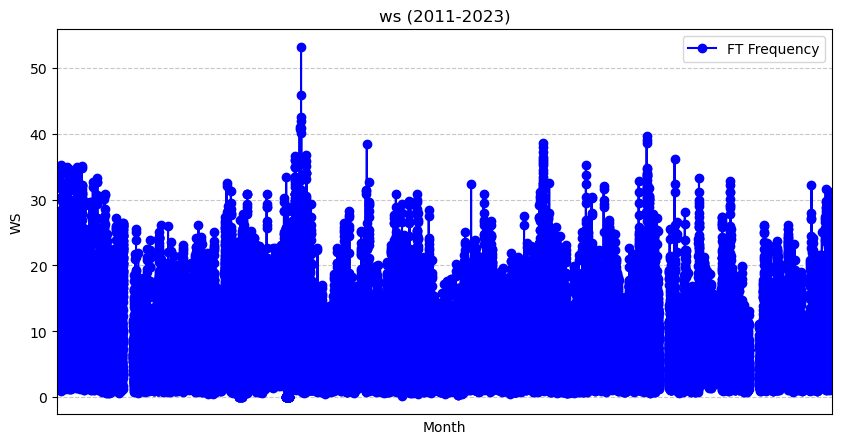

In [8]:
# Plot WS
plt.figure(figsize=(10, 5))
plt.plot(df.DATETIME, df.wind_speed, marker="o", linestyle="-", label="FT Frequency", color="blue")


# Formatting the plot
plt.xlabel("Month")
plt.ylabel("WS")
plt.title("ws (2011-2023)")
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(pd.Timestamp("2011-1-1"), pd.Timestamp("2024-1-1"))  # Set x-axis limits
# Show plot
plt.show()

In [ ]:
df.index = df.DATETIME
df.wind_speed.plot()

In [ ]:
# Plot SH
plt.figure(figsize=(10, 5))
plt.plot(df.DATETIME, df.SH, marker="o", linestyle="-", label="SH", color="blue")


# Formatting the plot
plt.xlabel("Month")
plt.ylabel("[gkg-1]")
plt.title("SH (2011-2023)")
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(pd.Timestamp("2011-1-1"), pd.Timestamp("2024-1-1"))  # Set x-axis limits

# Show plot
plt.show()

In [9]:
# --- Group by season and hour ---
grouped = df.groupby(['season', 'hour'])['SH']

# Compute mean, count, std, sem
summary_SH = grouped.agg(['mean', 'count', 'std'])
summary_SH['sem'] = summary_SH['std'] / np.sqrt(summary_SH['count'])

# Compute 95% confidence interval using the t-distribution
confidence_level = 0.95
degrees_freedom = summary_SH['count'] - 1
t_critical = stats.t.ppf((1 + confidence_level) / 2, degrees_freedom)

summary_SH['ci95'] = t_critical * summary_SH['sem']

# Optional: Reset index if you want a flat DataFrame
summary_SH = summary_SH.reset_index()

print(summary_SH.tail())


KeyError: 'season'

In [ ]:
# --- Group by season and hour ---
grouped = df.groupby(['season', 'hour'])['temperature']

# Compute mean, count, SEM, and 95% CI
#summary_temp = grouped.agg(['mean', 'count', sem]).reset_index()
#summary_temp['ci95'] = t.ppf(0.975, df=summary_temp['count'] - 1) * summary_temp['sem']

# Compute mean, count, std, sem
#sem is computed as std / sqrt(count)
summary_temp = grouped.agg(['mean', 'count', 'std'])
summary_temp['sem'] = summary_temp['std'] / np.sqrt(summary_temp['count'])

# Compute 95% confidence interval using the t-distribution
confidence_level = 0.95
degrees_freedom = summary_temp['count'] - 1
t_critical = stats.t.ppf((1 + confidence_level) / 2, degrees_freedom)

summary_temp['ci95'] = t_critical * summary_temp['sem']

# Optional: Reset index if you want a flat DataFrame
summary_temp = summary_temp.reset_index()


# --- Plot ---
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
colors = {'Winter': 'tab:blue', 'Spring': 'tab:green', 'Summer': 'tab:red', 'Autumn': 'tab:orange'}

plt.figure(figsize=(10, 6))
for season in seasons:
    data = summary_temp[summary_temp['season'] == season]
    plt.plot(data['hour'], data['mean'], label=season, color=colors[season], marker='o')
    plt.fill_between(
        data['hour'],
        data['mean'] - data['ci95'],
        data['mean'] + data['ci95'],
        color=colors[season],
        alpha=0.2
    )

plt.xlabel('Hour of Day')
plt.ylabel('Temperature [°C]')
#plt.title('Diel Variation of temperature by Season with 95% CI')
plt.xticks(range(0, 24))
plt.grid(True, which='both', axis='x', linestyle='--', alpha=0.5)
plt.legend(title='Season')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\temp_seas_diel.png", dpi=300)
plt.show()
summary_temp.to_csv("diel_temp_by_season.csv", index=False)

In [ ]:
summary_temp 

In [ ]:

# Plotting
plt.figure(figsize=(10, 6))

# Create a boxplot for each month across all years
sns.boxplot(x='month', y='temperature', data=df, color='white', showfliers=False, # Hide outliers
        whis=[5, 95],      # Whiskers representing 5th–95th percentiles
        showmeans=True,
        fill=False,
        meanprops={"marker": "D", "markerfacecolor": "red", "markeredgecolor": "black"},
        boxprops={'color': 'black'}, medianprops={'color': 'black'},
        whiskerprops={'color': 'black'}, capprops={'color': 'black'})

# Calculate means and overlay them as red diamonds with annotations
monthly_means = df.groupby('month')['SH'].mean()

# Annotate mean values above each marker
for month, mean in monthly_means.items():
    plt.text(month - 1, mean + 0.1, f'{mean:.2f}', color='black', ha='center')   

# Customize the plot
#plt.title("Monthly Boxplots with Mean Values (2011-2023)")
plt.xlabel("Month")
plt.ylabel("Temperature [°C]")
plt.xticks(ticks=np.arange(12), labels=[str(i) for i in range(1, 13)])
# Show the plot
plt.tight_layout()
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\Temp_box.png", dpi=300)
plt.show()

In [ ]:
# --- Group by season and hour ---
grouped = df.groupby(['season', 'hour'])['wind_speed']

# Compute mean, count, SEM, and 95% CI
#summary_temp = grouped.agg(['mean', 'count', sem]).reset_index()
#summary_temp['ci95'] = t.ppf(0.975, df=summary_temp['count'] - 1) * summary_temp['sem']

# Compute mean, count, std, sem
#sem is computed as std / sqrt(count)
summary_ws = grouped.agg(['mean', 'count', 'std'])
summary_ws['sem'] = summary_ws['std'] / np.sqrt(summary_ws['count'])

# Compute 95% confidence interval using the t-distribution
confidence_level = 0.95
degrees_freedom = summary_ws['count'] - 1
t_critical = stats.t.ppf((1 + confidence_level) / 2, degrees_freedom)

summary_ws['ci95'] = t_critical * summary_ws['sem']

# Optional: Reset index if you want a flat DataFrame
summary_ws = summary_ws.reset_index()


# --- Plot ---
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
colors = {'Winter': 'tab:blue', 'Spring': 'tab:green', 'Summer': 'tab:red', 'Autumn': 'tab:orange'}

plt.figure(figsize=(10, 6))
for season in seasons:
    data = summary_ws[summary_ws['season'] == season]
    plt.plot(data['hour'], data['mean'], label=season, color=colors[season], marker='o')
    plt.fill_between(
        data['hour'],
        data['mean'] - data['ci95'],
        data['mean'] + data['ci95'],
        color=colors[season],
        alpha=0.2
    )

plt.xlabel('Hour of Day')
plt.ylabel('Wind speed [m$s^-^1$]')
#plt.title('Diel Variation of temperature by Season with 95% CI')
plt.xticks(range(0, 24))
plt.grid(True, which='both', axis='x', linestyle='--', alpha=0.5)
plt.legend(title='Season')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\ws_seas_diel.png", dpi=300)
plt.show()
summary_ws.to_csv("diel_temp_by_season.csv", index=False)

In [ ]:

# Plotting
plt.figure(figsize=(10, 6))

# Create a boxplot for each month across all years
sns.boxplot(x='month', y='wind_speed', data=df, color='white', showfliers=False, # Hide outliers
        whis=[5, 95],      # Whiskers representing 5th–95th percentiles
        showmeans=True,
        fill=False,
        meanprops={"marker": "D", "markerfacecolor": "red", "markeredgecolor": "black"},
        boxprops={'color': 'black'}, medianprops={'color': 'black'},
        whiskerprops={'color': 'black'}, capprops={'color': 'black'})

# Calculate means and overlay them as red diamonds with annotations
monthly_means = df.groupby('month')['wind_speed'].mean()

# Annotate mean values above each marker
for month, mean in monthly_means.items():
    plt.text(month - 1, mean + 0.5, f'{mean:.2f}', color='black', ha='center')   

# Customize the plot
#plt.title("Monthly Boxplots with Mean Values (2011-2023)")
plt.xlabel("Month")
plt.ylabel('Wind speed [m$s^-1$]')
plt.xticks(ticks=np.arange(12), labels=[str(i) for i in range(1, 13)])
# Show the plot
plt.tight_layout()
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\ws_box.png", dpi=300)
plt.show()

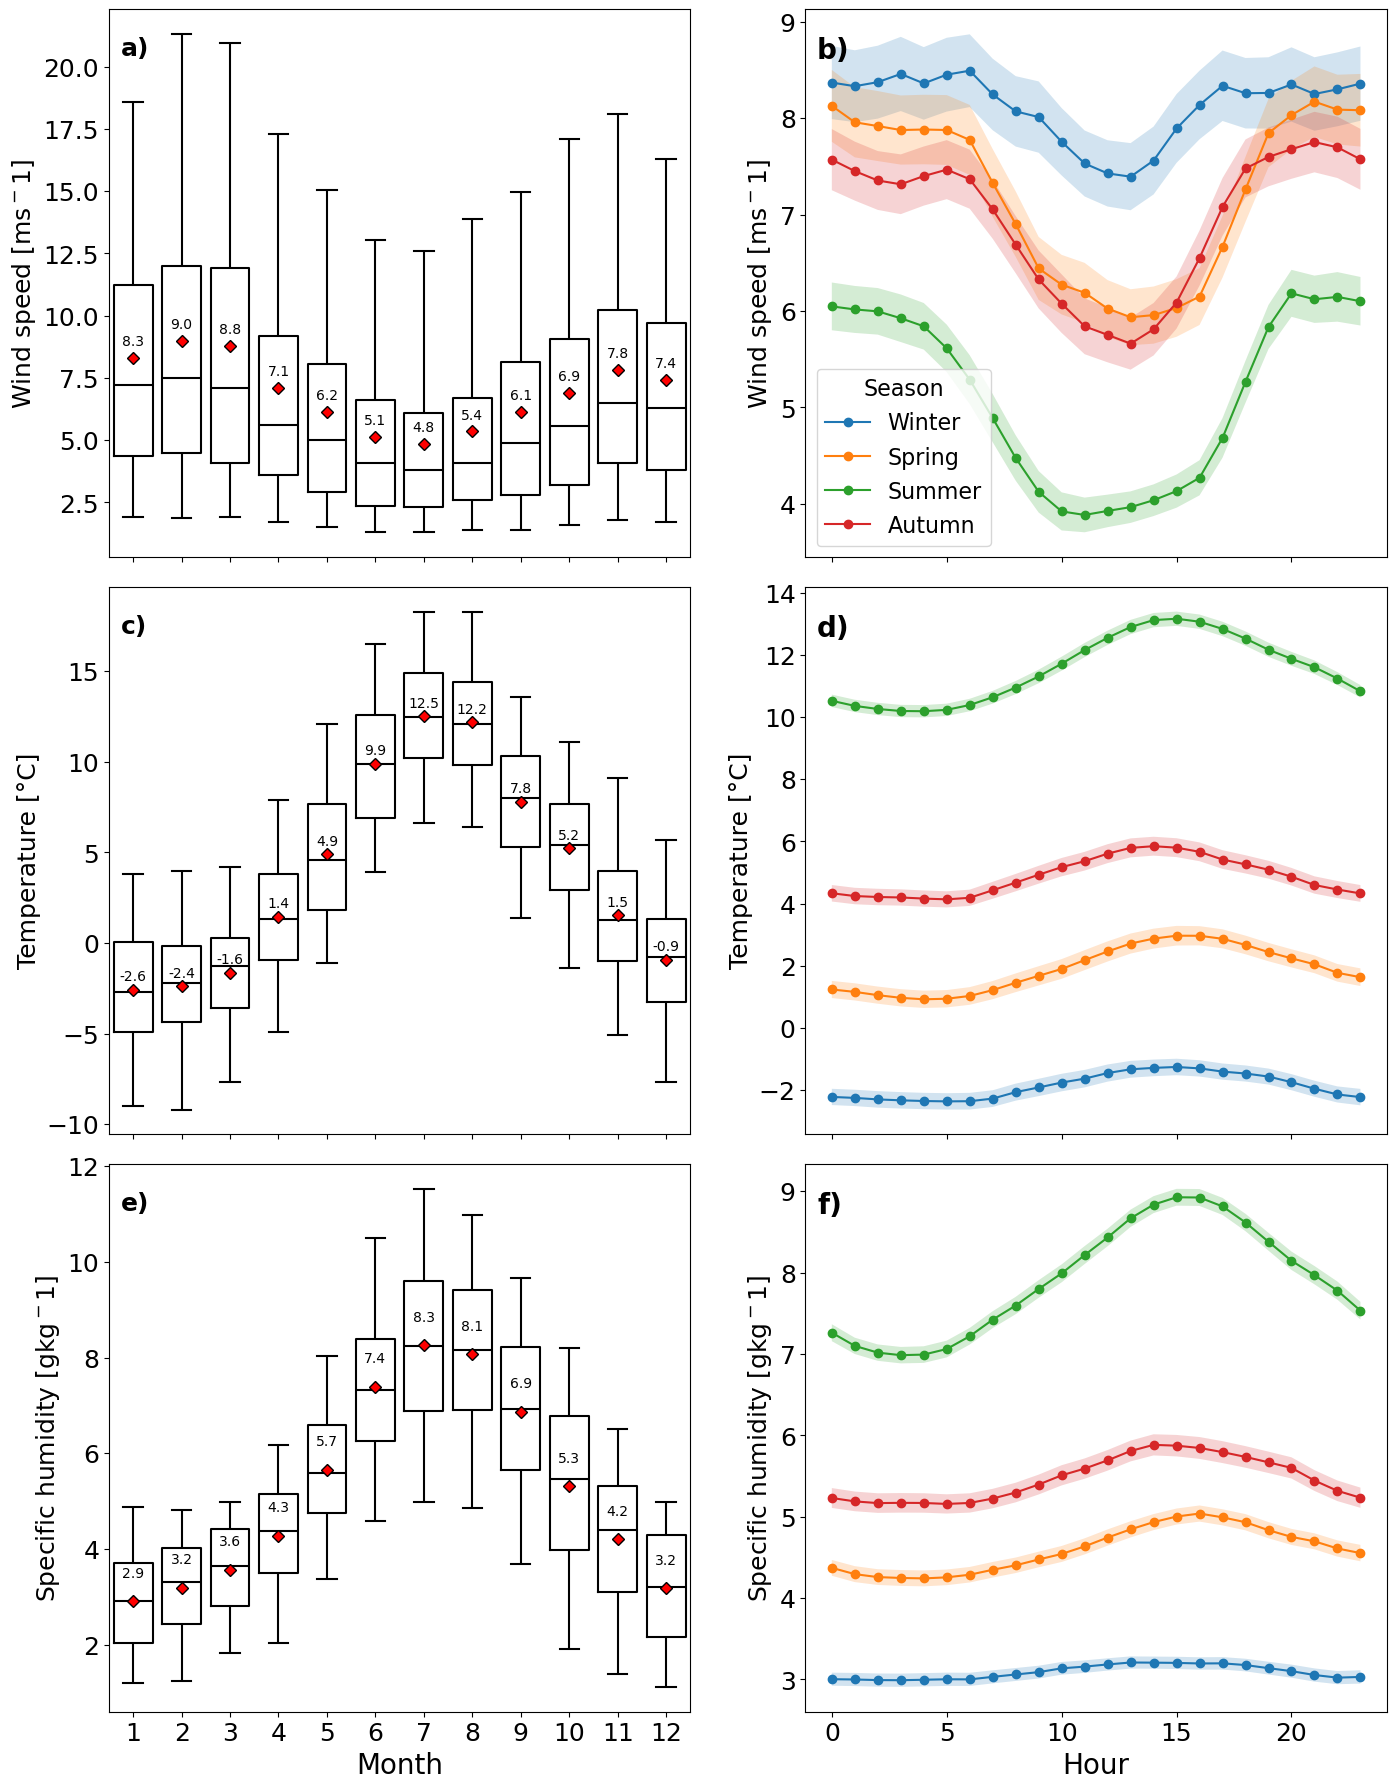

In [12]:
# 6 panels figs box plot of monthly means and diel variation by season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)

variables = ['wind_speed', 'temperature', 'SH']
var_labels = ['Wind speed [ms$^-1$]', 'Temperature [°C]', 'Specific humidity [gkg$^-1$]']
panel_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.flatten()

for i, var in enumerate(variables):
    # --- Left panel: Boxplot by month ---
    ax_box = axes[i * 2]
    sns.boxplot(data=df, x='month', y=var, ax=ax_box, showfliers=False, 
        whis=[5, 95],
        showmeans=True,
        fill=False,
        meanprops={"marker": "D", "markerfacecolor": "red", "markeredgecolor": "black"},
        boxprops={'color': 'black'}, medianprops={'color': 'black'},
        whiskerprops={'color': 'black'}, capprops={'color': 'black'})
    monthly_means = df.groupby('month')[var].mean()
    for month, mean in monthly_means.items():
        ax_box.text(month - 1, mean + 0.5, f'{mean:.1f}', color='black', ha='center')
    ax_box.text(0.02, 0.95, f"{panel_labels[i*2]}", transform=ax_box.transAxes, fontsize=18, va='top', ha='left', fontweight='bold')
    ax_box.set_ylabel(var_labels[i], fontsize=18)
    if i < 2:
        ax_box.set_xlabel('')
        ax_box.set_xticklabels([])
    else:
        ax_box.set_xlabel('Month', fontsize=20)
    # Set fontsize for xticks and yticks
    ax_box.tick_params(axis='x', labelsize=18)
    ax_box.tick_params(axis='y', labelsize=18)
    # --- Right panel: Diel variation by season with 95% CI ---
    ax_diel = axes[i * 2 + 1]
    grouped = df.groupby(['season', 'hour'])[var].agg(['mean', 'count', 'std']).reset_index()
    grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
    grouped['ci95'] = stats.t.ppf(0.975, grouped['count'] - 1) * grouped['sem']

    for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
        subset = grouped[grouped['season'] == season]
        ax_diel.plot(subset['hour'], subset['mean'], label=season, marker='o')
        ax_diel.fill_between(subset['hour'],
                             subset['mean'] - subset['ci95'],
                             subset['mean'] + subset['ci95'],
                             alpha=0.2)

    ax_diel.text(0.02, 0.95, f"{panel_labels[i*2+1]}", transform=ax_diel.transAxes, fontsize=20, va='top', ha='left', fontweight='bold')
    ax_diel.set_ylabel(var_labels[i], fontsize=18)
    # Only show legend in first row (i==0)
    if i == 0:
        ax_diel.legend(title='Season', fontsize=16, title_fontsize=16)
    else:
        if ax_diel.get_legend():
            ax_diel.get_legend().remove()
    if i < 2:
        ax_diel.set_xlabel('')
        ax_diel.set_xticklabels([])
    else:
        ax_diel.set_xlabel('Hour', fontsize=20)
    # Set fontsize for xticks and yticks
    ax_diel.tick_params(axis='x', labelsize=18)
    ax_diel.tick_params(axis='y', labelsize=18)

plt.tight_layout()
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\ws_t_SH_box_diel.png", dpi=300)
plt.show()



In [ ]:
# Prepare a combined DataFrame to export all diel variation stats
diel_dfs = []

for var in variables:
    diel = df.groupby(['season', 'hour'])[var].agg(['mean', 'count', 'std']).reset_index()
    diel['sem'] = diel['std'] / np.sqrt(diel['count'])
    diel['ci95'] = stats.t.ppf(0.975, diel['count'] - 1) * diel['sem']
    diel['variable'] = var  # Add variable name for identification
    diel_dfs.append(diel)

# Combine and export
diel_combined = pd.concat(diel_dfs, ignore_index=True)
diel_combined.to_csv('diel_variation_with_ci.csv', index=False)
# Save the summary DataFrame to a CSV file
diel_combined.to_csv("C:\\YEAR1\\NMVOC\\figures\\diel_variation_with_ci.csv", index=False)

In [ ]:

# Load the diel data
diel_df = pd.read_csv('diel_variation_with_ci.csv')

# Initialize list to store results
results = []

# Loop through each variable and season
for var in diel_df['variable'].unique():
    for season in diel_df['season'].unique():
        subset = diel_df[(diel_df['variable'] == var) & (diel_df['season'] == season)]

        # Find max and min mean values and corresponding hours
        max_row = subset.loc[subset['mean'].idxmax()]
        min_row = subset.loc[subset['mean'].idxmin()]

        results.append({
            'variable': var,
            'season': season,
            'max_mean': max_row['mean'],
            'max_hour': int(max_row['hour']),
            'min_mean': min_row['mean'],
            'min_hour': int(min_row['hour'])
        })

# Convert results to DataFrame and print
results_df = pd.DataFrame(results)
print(results_df)
